In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
from qiskit.circuit import Parameter
import math
import random
import numpy as np
import copy
import time
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator
from typing import Optional, List, Dict, Tuple, Union
from qiskit.result import Counts, Result

from qiskit import pulse, IBMQ
from qiskit.pulse.schedule import ScheduleBlock
from qiskit.pulse import Schedule
from qiskit.pulse.instructions import Call
from qiskit import transpile, schedule as build_schedule
from qiskit.providers.aer.pulse import duffing_system_model


import logging
logger = logging.getLogger()

# imports for qiskit dynamics simulation
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector

# optimizers
import random
from scipy.optimize import fmin_l_bfgs_b
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import QNSPSA

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


# Define the system (backend and noise)

In [ ]:
IBMQ.ibmq.load_account()

In [3]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_manila = provider.get_backend('ibmq_manila')
manila_prop = backend_manila.properties()

In [ ]:
# build the noise model
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

t1 = 100e3
t2 = 100e3

noise_thermal = qiskit_aer.noise.NoiseModel.from_backend(backend_manila, gate_error=True, thermal_relaxation=False,
                                                      readout_error=False)

for i in range(5):
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('reset', i)),
                                    "reset", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('id', i)),
                                    "id", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('sx', i)),
                                    "sx", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('x', i)),
                                    "x", [i])
    for j in range(5):
        try:
            noise_thermal.add_quantum_error(
                thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j])).expand(
                    thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j]))),
                                            "cx", [i, j])
        except:
            pass


# Define functions to run the simulation

In [7]:
def run_ansatz(circ, noise):
    sim_backend = AerSimulator(noise_model=noise)
    circ.snapshot('final', snapshot_type='density_matrix')
    circ_tthermal = transpile(circ, sim_backend, optimization_level=0)
    
    job = sim_backend.run(circ_tthermal)
    density_matrix_res = job.result().data(0)['snapshots']['density_matrix']['final'][0]['value']
    return density_matrix_res

In [8]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

In [9]:
from qiskit.result import marginal_counts
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def finite_sampling_measure(state, paulis, coeffs, leakage=False, shots=10000):
    ansatz_density_matrix = qiskit.quantum_info.DensityMatrix(state)
    if leakage:
        # filter out leakage
        reduced_density_matrix = qiskit.quantum_info.DensityMatrix(
            [list(ansatz_density_matrix.data[0][0:2]) + list(ansatz_density_matrix.data[0][3:5]),
             list(ansatz_density_matrix.data[1][0:2]) + list(ansatz_density_matrix.data[1][3:5]),
             list(ansatz_density_matrix.data[3][0:2]) + list(ansatz_density_matrix.data[3][3:5]),
             list(ansatz_density_matrix.data[4][0:2]) + list(ansatz_density_matrix.data[4][3:5])])
        leakage_prob = 1 - sum(reduced_density_matrix.probabilities())
        print("leakage percent: " + str(leakage_prob*100) + "%")
        ansatz_density_matrix = reduced_density_matrix / reduced_density_matrix.trace()

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = None
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                marginal_qubits = 1 - i

        measured_density_matrix = ansatz_density_matrix.evolve(measure_op)

        if shots is not None:
            counts = measured_density_matrix.sample_counts(shots)
            if marginal_qubits is not None:
                counts = marginal_counts(counts, [marginal_qubits])
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_density_matrix.probabilities_dict()
            if marginal_qubits is not None:
                probs = marginal_counts(probs, [marginal_qubits])
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

In [10]:
def evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots=None):
    ansatz_circ = ansatz(num_of_qubits, num_of_layers)
    binded_circ = ansatz_circ.bind_parameters(theta)
        
    print(theta)
    ansatz_result = run_ansatz(binded_circ, noise_model)
    expval, stddev = finite_sampling_measure(ansatz_result, paulis[1:], coeffs[1:], leakage=False, shots=shots)
    print("energy: " + str(expval + coeffs[0]))
    # in case I will want to return also the varience
    # return expval, stddev
    
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    states.append(ansatz_result)
    return expval.real

In [23]:
def calculate_energy(theta):
    paulis = all_paulis[-1]
    coeffs = all_coeffs[-1]
    noise_model = noise_thermal
    num_of_qubits = 2
    num_of_layers = 1
    shots = 10000
    energy = evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots)
    return energy

## Define the ansatz

In [12]:
def ansatz(num_of_qubits, num_of_layers):
    circ = QuantumCircuit(num_of_qubits)
    counter = 0
    for i in range(num_of_qubits):
        circ.ry(Parameter('θ_' + str(counter)), i)
        counter += 1
    for layer in range(num_of_layers):
        # alternating entangling layer
        for i in range(0, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(1, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(num_of_qubits):
            circ.ry(Parameter('θ_' + str(counter)), i)
            counter += 1
    return circ

# Functions to build the problem parameters

In [13]:
def get_qubit_op_heh(dist, mapper="parity"):
    molecule = Molecule(geometry=[["He", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=1, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [14]:
def get_hf_energy(dist):
    temp_mol = gto.M(atom = 'H 0 0 0; H 0 0 ' + str(dist), basis = 'sto3g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [15]:
def get_accurate_state(dist):
    temp_qubit_op = get_qubit_op_heh(dist)[0]
    eigen_values, eigen_vectors = np.linalg.eigh(temp_qubit_op.to_matrix())
    min_eigen_value = eigen_values[0]
    min_eigen_vector = eigen_vectors.transpose()[0]
    return min_eigen_value, min_eigen_vector

In [16]:
def get_exact_energies(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op_heh(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [17]:
def get_paulis_and_coeffs(dist):
    qubit_op = get_qubit_op_heh(dist)[0]
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

# Visualisation functions

In [18]:
def plot_convergence(values_hist_arr, dist):
    values_hist_arr_real = np.array(values_hist_arr[dist])
    paulis, coeffs = get_paulis_and_coeffs(dist)
    values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = np.array([spsa_value.real for spsa_value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_hist_arr[dist]))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_hist_arr[dist]))), [min_eigenvalue] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("iteration")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title("H_2 SPSA convergence")
    plt.show()

In [19]:
def plot_energies(energies, calculated_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, energies, lw=3, label="Exact Energy")
    plt.plot(distances, calculated_energies, lw=3, label="VQE Energy")
    plt.fill_between(distances, np.array(energies)-0.0016, np.array(energies)+0.0016, 
                     alpha=0.2, facecolor='#089FFF', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [20]:
def plot_energies_error(energies, calculated_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, np.abs(np.array(energies) - np.array(calculated_energies)), lw=3, label="Energy Error")
    plt.axhline(0.0016, linestyle='--', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy Error')
    plt.legend()
    plt.show()

# Run the simulation

In [24]:
from qiskit.algorithms.optimizers import SPSA

dists = [0.3, 0.5, 0.7, 0.8, 1, 1.5, 2, 3]

thetas_hist = {}
values_hist = {}
states_hist = {}
all_paulis = []
all_coeffs =[]

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy - nuclear_repulsion_energy

    initial_theta = [np.pi, 0, 0, 0]

    thetas = []
    values = []
    states = []

    tic = time.perf_counter()
    spsa = SPSA(maxiter=200)
    vqe_result = spsa.minimize(calculate_energy, initial_theta)
    toc = time.perf_counter()

    thetas_hist[dist] = copy.deepcopy(thetas)
    values_hist[dist] = copy.deepcopy(values)
    states_hist[dist] = copy.deepcopy(states)

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(thetas[opt_theta_index]))
    res = min(values).real + coeffs[0]
    print("min eigen_value found: " + str(res))
    print("absolute error: " + str(np.abs(res - target_energy)))
    print("number of function evaluations: " + str(vqe_result.nfev))


#########################################
Solving for distance 0.3:
#########################################
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-3.4088312264379437+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-3.4317963409198287+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-3.4178957532578806+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-3.3187984305046574+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-3.478797721953712+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-3.3597189116276613+0j)
[ 3.34159265  0.2        -0.2         0.2       ]
energy: (-3.3808314422976418+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-3.35678609402262+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-3.290516263543416+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-3.4138875633564036+0j)
[ 2.94159265  0.2         0.2        -0.2       ]
energy: (-3.447285

energy: (-3.868489841903121+0j)
[ 5.72867816 -7.07103298 -8.83832145 -1.26752019]
energy: (-3.3418603645789258+0j)
[ 7.01219848 -5.78751266 -7.55480113 -0.27183757]
energy: (-3.530500286710437+0j)
[ 6.72436078 -6.07535036 -7.84263884  0.01600013]
energy: (-4.094914518958011+0j)
[ 5.96589393 -6.8338172  -8.8878483   0.77446698]
energy: (-4.985521230949958+0j)
[ 5.67915131 -7.12055983 -8.60110568  1.0612096 ]
energy: (-4.535146886900107+0j)
[ 6.49850909 -6.30120205 -9.42046346  0.24185182]
energy: (-5.2683185442015805+0j)
[ 6.7842004  -6.01551074 -9.70615477 -0.04383949]
energy: (-5.105326142391494+0j)
[ 6.49270663 -6.59168506 -9.414661    0.24765428]
energy: (-5.2856919615479026+0j)
[ 6.20802608 -6.30700451 -9.12998045  0.53233483]
energy: (-5.128231526759703+0j)
[ 6.76843334 -6.58370432 -9.40668026 -0.02807243]
energy: (-5.090754392070263+0j)
[ 6.48472589 -6.86741177 -9.69038771  0.25563502]
energy: (-5.186383580962846+0j)
[ 6.60303906 -7.03186803 -9.85484397  0.42009128]
energy: (-5.0

energy: (-5.25449560018959+0j)
[ 6.50303488 -6.91358795 -9.20425479  0.36207822]
energy: (-5.249050118865378+0j)
[ 6.24475069 -6.65530376 -9.46253897  0.62036241]
energy: (-5.257779065994447+0j)
[ 6.23547159 -6.64602466 -9.47181808  0.37169811]
energy: (-5.287443617722869+0j)
[ 6.49341499 -6.90396806 -9.21387468  0.62964152]
energy: (-5.2915321195626905+0j)
[ 6.24003666 -6.90819719 -9.20964554  0.37626319]
energy: (-5.217499649985031+0j)
[ 6.49764413 -6.65058973 -9.467253    0.63387065]
energy: (-5.255292460600466+0j)
[ 6.28058581 -6.86764805 -9.50747091  0.67408856]
energy: (-5.286246091623249+0j)
[ 6.53786204 -6.61037182 -9.25019469  0.41681233]
energy: (-5.266706930138957+0j)
[ 6.51695296 -6.88823048 -9.27110377  0.43772141]
energy: (-5.269548436393003+0j)
[ 6.26000338 -6.6312809  -9.52805334  0.69467099]
energy: (-5.222449301508475+0j)
[ 6.56648533 -6.68113546 -9.22157139  0.38818904]
energy: (-5.266247220464035+0j)
[ 6.30985795 -6.93776285 -9.47819878  0.64481643]
energy: (-5.3018

energy: (-5.293631145804268+0j)
[ 6.51386285 -6.77805421 -9.4917567   0.48499793]
energy: (-5.270698244878715+0j)
[ 6.2686316  -7.02328546 -9.24652545  0.73022918]
energy: (-5.27197692083212+0j)
[ 6.26765843 -7.02425863 -9.49058935  0.48616528]
energy: (-5.258145869923862+0j)
[ 6.5126955  -6.77922156 -9.24555228  0.73120235]
energy: (-5.264153702353255+0j)
[ 6.27276356 -6.77430895 -9.48548421  0.73611496]
energy: (-5.256975859888421+0j)
[ 6.51760811 -7.01915349 -9.24063967  0.49127042]
energy: (-5.25193448702256+0j)
[ 6.26867225 -7.01487129 -9.48957553  0.49555262]
energy: (-5.264152482309104+0j)
[ 6.51332591 -6.77021763 -9.24492187  0.74020628]
energy: (-5.255257259834955+0j)
[ 6.26140811 -7.02213543 -9.49683967  0.48828848]
energy: (-5.258400430716324+0j)
[ 6.50587249 -6.77767105 -9.25237528  0.73275286]
energy: (-5.271422182211465+0j)
[ 6.51650991 -6.76703363 -9.48601455  0.74339028]
energy: (-5.242074984828792+0j)
[ 6.27223322 -7.01131032 -9.24173786  0.49911359]
energy: (-5.241816

energy: (-5.295146479497269+0j)
[ 6.28133187 -6.81752198 -9.47239626  0.53734857]
energy: (-5.295469844672733+0j)
[ 6.51847727 -7.05466738 -9.23525087  0.77449396]
energy: (-5.296187377024708+0j)
[ 6.28190788 -6.81809799 -9.47182025  0.53792458]
energy: (-5.293703169636107+0j)
[ 6.51891837 -7.05510849 -9.23480976  0.77493507]
energy: (-5.294455307614499+0j)
[ 6.51938292 -7.05557303 -9.47122163  0.5385232 ]
energy: (-5.24960293222621+0j)
[ 6.2825065  -6.81869661 -9.23434521  0.77539962]
energy: (-5.263396751387844+0j)
[ 6.50959466 -7.04578477 -9.22469019  0.54831146]
energy: (-5.263009879761673+0j)
[ 6.27285148 -6.80904159 -9.46143337  0.78505464]
energy: (-5.260863083517198+0j)
[ 6.51103725 -7.04722736 -9.2232476   0.78347961]
energy: (-5.29276407640249+0j)
[ 6.27442651 -6.81061662 -9.45985834  0.54686887]
energy: (-5.294459135403439+0j)
[ 6.50978342 -7.04597353 -9.22450143  0.78222578]
energy: (-5.292865583196153+0j)
[ 6.27330431 -6.80949442 -9.46098054  0.54574667]
energy: (-5.287501

energy: (-3.428935664340301+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-3.2925495741941124+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-3.376564582028652+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-3.2480555377974953+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-3.3702305807476534+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-3.3579800534468824+0j)
[ 3.06880285 -0.0727898  -0.30016479  0.0727898 ]
energy: (-3.258857772760494+0j)
[ 3.44175745  0.30016479  0.0727898  -0.30016479]
energy: (-3.5058668027241877+0j)
[ 4.69606032  1.91245755  1.68508255 -1.55446767]
energy: (-3.287920386382586+0j)
[ 5.0540502   1.55446767  1.32709268 -1.91245755]
energy: (-3.3508405010695723+0j)
[ 5.38567578  1.57057991  1.34320492 -1.8963453 ]
energy: (-3.429562855334276+0j)
[ 5.03793796  1.22284209  0.9954671  -2.24408313]
energy: (-3.226410734157164+0j)
[ 5.98315424  2.16805838  1.94068338 -0.9588785 ]
energy: (-

energy: (-4.709997718032685+0j)
[ 5.65833051  4.42364165  2.80740971 -4.4762876 ]
energy: (-4.703651667524375+0j)
[ 5.66698625  4.7017386   2.79875398 -4.75438455]
energy: (-4.7001623858565225+0j)
[ 5.93642746  4.43229739  2.52931277 -4.48494334]
energy: (-4.707831034041168+0j)
[ 5.94618347  4.69144423  2.51955675 -4.74409017]
energy: (-4.70684312904284+0j)
[ 5.67728062  4.42254138  2.7884596  -4.47518732]
energy: (-4.711298689684121+0j)
[ 5.9401528   4.41703757  2.52558742 -4.46968352]
energy: (-4.708855660496448+0j)
[ 5.67177682  4.68541356  2.79396341 -4.73805951]
energy: (-4.702567214593873+0j)
[ 5.94795579  4.40923458  2.51778443 -4.46188053]
energy: (-4.706385560428096+0j)
[ 5.68009563  4.67709475  2.78564459 -4.72974069]
energy: (-4.706620488256071+0j)
[ 5.68004996  4.67714042  2.78569027 -4.46243142]
energy: (-4.701548536502236+0j)
[ 5.9474049   4.40978548  2.51833532 -4.72978637]
energy: (-4.691418709622205+0j)
[ 5.66755567  4.68963471  2.79818456 -4.71679706]
energy: (-4.7042

energy: (-4.715478850690001+0j)
[ 5.97116256  4.3542506   2.55953391 -4.37111688]
energy: (-4.707490432958099+0j)
[ 5.96365703  4.61272713  2.81801044 -4.37862241]
energy: (-4.709006556174975+0j)
[ 5.71268603  4.36175614  2.56703945 -4.62959341]
energy: (-4.713549742660705+0j)
[ 5.95935629  4.60842639  2.8137097  -4.38292315]
energy: (-4.712642707485264+0j)
[ 5.7086349   4.35770501  2.56298832 -4.63364453]
energy: (-4.705867052443589+0j)
[ 5.96543009  4.36402575  2.56930906 -4.6273238 ]
energy: (-4.704127131798238+0j)
[ 5.71495564  4.6145002   2.81978351 -4.37684935]
energy: (-4.69882468462481+0j)
[ 5.97013411  4.60955187  2.56460504 -4.38179767]
energy: (-4.682011013051531+0j)
[ 5.71990397  4.35932173  2.81483518 -4.63202781]
energy: (-4.687967540438583+0j)
[ 5.71462951  4.35404728  2.82010964 -4.38731386]
energy: (-4.7072912049978255+0j)
[ 5.96461792  4.60403568  2.57012123 -4.63730227]
energy: (-4.714856841317574+0j)
[ 5.97131837  4.36098693  2.56342079 -4.39425352]
energy: (-4.7090

energy: (-4.716967990004174+0j)
[ 5.72142381  4.37456559  2.58677159 -4.64869578]
energy: (-4.71284293230598+0j)
[ 5.9622445   4.61538628  2.82759227 -4.40787509]
energy: (-4.709837654948837+0j)
[ 5.71925272  4.61305575  2.5846005  -4.41020562]
energy: (-4.721823364041551+0j)
[ 5.95991396  4.3723945   2.82526174 -4.65086687]
energy: (-4.714179309838816+0j)
[ 5.95412856  4.61868286  2.81947634 -4.40457852]
energy: (-4.7142430697457876+0j)
[ 5.71362561  4.37817991  2.57897339 -4.64508146]
energy: (-4.7073945967573465+0j)
[ 5.7187999   4.38335419  2.58414768 -4.63990718]
energy: (-4.714583461788954+0j)
[ 5.95914567  4.62369997  2.82449345 -4.3995614 ]
energy: (-4.71429498583233+0j)
[ 5.71866398  4.62340799  2.82420147 -4.6400431 ]
energy: (-4.710928766847701+0j)
[ 5.95885369  4.38321827  2.58401176 -4.39985338]
energy: (-4.712070905435983+0j)
[ 5.95962056  4.38245141  2.82327964 -4.39908651]
energy: (-4.738046856162072+0j)
[ 5.71958581  4.62248616  2.58324489 -4.63912127]
energy: (-4.7379

[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-3.331481497477924+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-3.1966114440572007+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-3.21416847691567+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-3.340519808841497+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-3.3095748049237517+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-3.3022472219029915+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-3.2980731574505215+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-3.314416514653437+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-3.213516219605758+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-3.3404653792563486+0j)
[ 2.94159265 -0.2        -0.2         0.2       ]
energy: (-3.262205192961732+0j)
[ 3.34159265  0.2         0.2        -0.2       ]
energy: (-3.3863000290542167+0j)
[ 3.34159265  0.2  

energy: (-4.322134547615471+0j)
[ 5.63370675 -1.55857524  2.47613552  1.51430338]
energy: (-4.313182699854195+0j)
[ 5.62099417 -1.85697913  2.17773163  1.81270728]
energy: (-4.306323922055274+0j)
[ 5.33530286 -1.57128782  2.46342294  1.52701597]
energy: (-4.298109879038362+0j)
[ 5.63146938 -1.86745434  2.16725642  1.53850194]
energy: (-4.286790254900785+0j)
[ 5.34678883 -1.58277379  2.45193697  1.82318248]
energy: (-4.295674982845878+0j)
[ 5.3356052  -1.85529761  2.17941315  1.55065866]
energy: (-4.304453204704065+0j)
[ 5.61931265 -1.57159016  2.4631206   1.83436612]
energy: (-4.298279618401223+0j)
[ 5.61087114 -1.8628011   2.17190966  1.8259246 ]
energy: (-4.302346915139652+0j)
[ 5.32810171 -1.58003167  2.45467909  1.54315517]
energy: (-4.298169057652132+0j)
[ 5.61572583 -1.86765579  2.16705497  1.54891514]
energy: (-4.291234664799823+0j)
[ 5.33386168 -1.58579164  2.44891912  1.8307793 ]
energy: (-4.290996626445425+0j)
[ 5.61558612 -1.86751608  2.16719468  1.83004435]
energy: (-4.2972

energy: (-4.300502574869521+0j)
[ 5.38325437 -1.88129043  2.2323885   1.83462963]
energy: (-4.323558866573596+0j)
[ 5.64086183 -1.62368297  2.48999596  1.57702216]
energy: (-4.32653419825894+0j)
[ 5.38580061 -1.87874419  2.23493474  1.57480716]
energy: (-4.301212536485666+0j)
[ 5.64307684 -1.62146796  2.49221096  1.83208338]
energy: (-4.304115871376152+0j)
[ 5.38827218 -1.61932305  2.2374063   1.8342283 ]
energy: (-4.305103834564545+0j)
[ 5.64522175 -1.87627262  2.49435588  1.57727872]
energy: (-4.3027708182117435+0j)
[ 5.38659011 -1.87426836  2.49235162  1.83591037]
energy: (-4.30175834180619+0j)
[ 5.64321749 -1.61764097  2.23572423  1.57928298]
energy: (-4.30010807173701+0j)
[ 5.38545334 -1.87540513  2.23717883  1.58073758]
energy: (-4.311924174655061+0j)
[ 5.64176289 -1.61909558  2.49348838  1.83704714]
energy: (-4.304111272326621+0j)
[ 5.63550951 -1.88134491  2.487235    1.83079375]
energy: (-4.3247097361303295+0j)
[ 5.37951356 -1.62534896  2.23123905  1.5747978 ]
energy: (-4.31970

energy: (-4.29883304756302+0j)
[ 5.68360323 -1.63223015  2.52472845  1.82745455]
energy: (-4.309698842536664+0j)
[ 5.43875868 -1.87707469  2.27988391  1.58261001]
energy: (-4.307690519014054+0j)
[ 5.68475667 -1.87573036  2.5258819   1.58395434]
energy: (-4.305504002283789+0j)
[ 5.44010301 -1.6310767   2.28122824  1.828608  ]
energy: (-4.305490824893794+0j)
[ 5.44020581 -1.6311795   2.52579542  1.58404082]
energy: (-4.309290785947658+0j)
[ 5.6846702  -1.87564388  2.28133104  1.8285052 ]
energy: (-4.305784353860611+0j)
[ 5.6824126  -1.6291096   2.52786533  1.58197091]
energy: (-4.32047705335628+0j)
[ 5.43813591 -1.87338629  2.28358864  1.8262476 ]
energy: (-4.3201411265308565+0j)
[ 5.68252604 -1.87308671  2.52797877  1.82594803]
energy: (-4.321505298543622+0j)
[ 5.43843548 -1.62899616  2.28388821  1.58185747]
energy: (-4.319448281331776+0j)
[ 5.43978753 -1.6303482   2.52914621  1.82711547]
energy: (-4.308559191676219+0j)
[ 5.68369348 -1.87425416  2.28524026  1.58320952]
energy: (-4.29833

energy: (-4.308690662347246+0j)
[ 5.70871493 -1.63844777  2.31586168  1.60149819]
energy: (-4.306017838791265+0j)
[ 5.47049459 -1.87666811  2.31733884  1.83971853]
energy: (-4.324338009032447+0j)
[ 5.70723777 -1.63992493  2.55408202  1.60297536]
energy: (-4.328022528619956+0j)
[ 5.70911058 -1.63805212  2.55595483  1.83771329]
energy: (-4.316079297321983+0j)
[ 5.47249984 -1.87466286  2.31934409  1.60110255]
energy: (-4.304743703490853+0j)
[ 5.71499374 -1.86864807  2.32535888  1.60711734]
energy: (-4.301960374606758+0j)
[ 5.47851463 -1.63216896  2.56183799  1.84359645]
energy: (-4.3048061512091405+0j)
[ 5.47709069 -1.86709329  2.32691366  1.84502039]
energy: (-4.313577140116734+0j)
[ 5.71343896 -1.63074502  2.56326193  1.60867211]
energy: (-4.319551007677926+0j)
[ 5.71649184 -1.86391036  2.56631481  1.84183746]
energy: (-4.327374388095913+0j)
[ 5.48027362 -1.62769215  2.33009659  1.60561924]
energy: (-4.327241431821504+0j)
[ 5.48040746 -1.62782599  2.33023043  1.84184202]
energy: (-4.306

energy: (-3.3409126523927357+0j)
[ 3.73551626  0.59392361  0.59392361 -0.59392361]
energy: (-3.5002316570105014+0j)
[ 4.10847086  0.9668782   0.9668782  -0.9668782 ]
energy: (-3.428835837926613+0j)
[ 3.40658563  0.26499298  0.26499298 -0.62298285]
energy: (-3.476225952430199+0j)
[ 3.76457551  0.62298285  0.62298285 -0.26499298]
energy: (-3.3774777726073433+0j)
[ 3.03195328  0.23809845  0.23809845 -0.9976152 ]
energy: (-3.6019486780815524+0j)
[ 3.37969111 -0.10963937 -0.10963937 -0.64987737]
energy: (-3.2958502291166822+0j)
[ 2.01666167  1.25339007  1.25339007 -1.67291847]
energy: (-4.14138244527678+0j)
[ 2.35665001  0.91340173  0.91340173 -2.01290681]
energy: (-4.0785587420848515+0j)
[ 2.16649922  1.43733744  1.43733744 -1.48897111]
energy: (-4.11102820453291+0j)
[ 1.8327143   1.10355251  1.10355251 -1.82275603]
energy: (-4.100076091058661+0j)
[ 2.19368283  1.13589264  1.13589264 -1.7904159 ]
energy: (-4.1162973807388985+0j)
[ 1.86505443  1.46452104  1.46452104 -1.4617875 ]
energy: (-4

energy: (-4.143235002418836+0j)
[ 1.52331707  1.57834911  1.59810634 -1.43500659]
energy: (-4.142948593116117+0j)
[ 1.79118593  1.5778352   1.33023748 -1.70287544]
energy: (-4.1488415007815655+0j)
[ 1.52383098  1.31048025  1.59759243 -1.4355205 ]
energy: (-4.159427141854829+0j)
[ 1.7813708   1.56802007  1.60691254 -1.42620039]
energy: (-4.141314351099048+0j)
[ 1.51451087  1.30116014  1.34005261 -1.69306032]
energy: (-4.131116235158517+0j)
[ 1.52388649  1.31053576  1.34942823 -1.68368469]
energy: (-4.140401501841881+0j)
[ 1.79026121  1.57691048  1.61580295 -1.41730998]
energy: (-4.138265217675334+0j)
[ 1.5222284   1.57477662  1.34777014 -1.68534279]
energy: (-4.133621868343862+0j)
[ 1.78812735  1.30887767  1.61366909 -1.41944383]
energy: (-4.135039589316348+0j)
[ 1.52370886  1.30786386  1.6146829  -1.41843003]
energy: (-4.153786274604444+0j)
[ 1.78914116  1.57329616  1.3492506  -1.68386233]
energy: (-4.1478969050666485+0j)
[ 1.78377643  1.56793143  1.61958975 -1.41352318]
energy: (-4.14

energy: (-4.137346524213596+0j)
[ 1.51550544  1.56019787  1.34973074 -1.70458833]
energy: (-4.1397394241904335+0j)
[ 1.51406888  1.31164602  1.34829419 -1.70602489]
energy: (-4.143320809026065+0j)
[ 1.76405729  1.56163443  1.5982826  -1.45603648]
energy: (-4.151151334583212+0j)
[ 1.76900982  1.31683777  1.35348593 -1.45108395]
energy: (-4.152980934972773+0j)
[ 1.51926062  1.56658696  1.60323513 -1.70083314]
energy: (-4.152785270258778+0j)
[ 1.51950513  1.56634245  1.35347816 -1.70058863]
energy: (-4.1402647673134325+0j)
[ 1.76901759  1.31683     1.60299062 -1.45107618]
energy: (-4.136629735632537+0j)
[ 1.51728989  1.56855769  1.35126292 -1.70280387]
energy: (-4.140280909760179+0j)
[ 1.76656803  1.31927956  1.60054106 -1.45352574]
energy: (-4.13898342978955+0j)
[ 1.51657721  1.56927037  1.35055024 -1.70351655]
energy: (-4.1416651106994+0j)
[ 1.76562341  1.32022418  1.59959644 -1.45447036]
energy: (-4.137976374896436+0j)
[ 1.51434702  1.57150057  1.34832005 -1.70574675]
energy: (-4.13769

energy: (-4.1394100594074255+0j)
[ 1.51302802  1.32121046  1.34919207 -1.43350829]
energy: (-4.134685246783207+0j)
[ 1.75597849  1.56416093  1.35179676 -1.43611299]
energy: (-4.155504558536097+0j)
[ 1.51563272  1.32381515  1.59214254 -1.67645877]
energy: (-4.147221248348722+0j)
[ 1.76031478  1.3283075   1.34746047 -1.4317767 ]
energy: (-4.1495973720602555+0j)
[ 1.52012507  1.56849722  1.58765019 -1.67196642]
energy: (-4.153476667931924+0j)
[ 1.51814185  1.33044568  1.34959865 -1.67394963]
energy: (-4.141201458331116+0j)
[ 1.75817661  1.57048043  1.5896334  -1.43391488]
energy: (-4.146504246667876+0j)
[ 1.52102665  1.33333047  1.59236432 -1.67106484]
energy: (-4.15591930125861+0j)
[ 1.76090752  1.57321135  1.35248344 -1.43118396]
energy: (-4.1512509050929935+0j)
[ 1.51863896  1.33094279  1.35502394 -1.67345252]
energy: (-4.142843101904443+0j)
[ 1.75836703  1.57067085  1.594752   -1.43372446]
energy: (-4.142228913863287+0j)
[ 1.75796799  1.3306955   1.59435297 -1.43412349]
energy: (-4.13

energy: (-3.1949509054323544+0j)
[ 2.94159265  0.2         0.2        -0.2       ]
energy: (-3.232208857626379+0j)
[ 3.34159265 -0.2        -0.2         0.2       ]
energy: (-3.1807125959302507+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-3.2353066342850463+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-3.112725175111719+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-3.2393997136944286+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-3.111138304408908+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-3.1178418976946976+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-3.257021356276735+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-3.1938401914896435+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-3.14007129580139+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-3.2270796480950854+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-3.0795262512

energy: (-3.8737986526690555+0j)
[ 3.07065968 -1.49543787  0.22710837  1.29632755]
energy: (-3.8505559030645102+0j)
[ 3.10527818 -1.53005637  0.19248987  1.33094605]
energy: (-3.8745372090411863+0j)
[ 3.38898563 -1.81376382 -0.09121758  1.61465351]
energy: (-3.855801388628227+0j)
[ 3.36146645 -1.50347521  0.21907103  1.58713432]
energy: (-3.897263055805931+0j)
[ 3.07869702 -1.78624464 -0.0636984   1.30436489]
energy: (-3.8955632240580984+0j)
[ 3.08156383 -1.78337782  0.22103257  1.30723171]
energy: (-3.880413399967685+0j)
[ 3.36342799 -1.50151367 -0.06083158  1.58909586]
energy: (-3.8778141590938064+0j)
[ 3.07836786 -1.7865738   0.22422854  1.30403573]
energy: (-3.88499197724207+0j)
[ 3.35935736 -1.5055843  -0.05676095  1.58502523]
energy: (-3.881236855440126+0j)
[ 3.35376565 -1.511176    0.22897429  1.57943353]
energy: (-3.895779454661603+0j)
[ 3.07362211 -1.79131955 -0.05116925  1.29928998]
energy: (-3.894715447117025+0j)
[ 3.07547441 -1.51014269 -0.04931695  1.30114228]
energy: (-3.

energy: (-3.874128826527243+0j)
[ 3.24036016 -1.66012854  0.31124713  1.24160646]
energy: (-3.877084971417202+0j)
[ 3.49453761 -1.6576786   0.05706969  1.23915652]
energy: (-3.8800887667103003+0j)
[ 3.23791022 -1.91430599  0.31369708  1.49578391]
energy: (-3.8822232826566427+0j)
[ 3.49250506 -1.65971115  0.05910223  1.49749862]
energy: (-3.886536722705496+0j)
[ 3.23619551 -1.9160207   0.31541179  1.24118906]
energy: (-3.8918499281938934+0j)
[ 3.48771304 -1.92049913  0.06389426  1.49270659]
energy: (-3.8769081593237695+0j)
[ 3.23171708 -1.66450317  0.31989021  1.23671064]
energy: (-3.878116564611528+0j)
[ 3.48651048 -1.91929657  0.32078331  1.23581754]
energy: (-3.9010449344776266+0j)
[ 3.23082399 -1.66361008  0.06509682  1.49150403]
energy: (-3.901803088362336+0j)
[ 3.48570429 -1.91849038  0.06459606  1.23662373]
energy: (-3.8946128753904246+0j)
[ 3.23032323 -1.66310932  0.31997712  1.49200479]
energy: (-3.891728125660112+0j)
[ 3.48802529 -1.66573182  0.06227506  1.23430274]
energy: (-

energy: (-3.8877947570730216+0j)
[ 3.54909733 -2.00807897  0.36277167  1.42259449]
energy: (-3.893600359066278+0j)
[ 3.30463295 -1.76361459  0.11830729  1.17813011]
energy: (-3.8910074308935956+0j)
[ 3.30651564 -2.00977397  0.36446666  1.1800128 ]
energy: (-3.8951262497890795+0j)
[ 3.55079233 -1.76549728  0.12018998  1.42428949]
energy: (-3.88989289073105+0j)
[ 3.54710253 -2.01327764  0.36797033  1.42059969]
energy: (-3.8925125821908675+0j)
[ 3.30301198 -1.76918708  0.12387977  1.17650914]
energy: (-3.898945587573199+0j)
[ 3.5426057  -2.00878081  0.11956755  1.17219691]
energy: (-3.889207998929921+0j)
[ 3.29869975 -1.76487485  0.3634735   1.41610287]
energy: (-3.8985326965142226+0j)
[ 3.53615367 -2.00232878  0.12601958  1.17864894]
energy: (-3.9018861016803514+0j)
[ 3.29243081 -1.75860591  0.36974245  1.42237181]
energy: (-3.8932737024339366+0j)
[ 3.54191565 -2.00809076  0.36379887  1.41642823]
energy: (-3.899464347315922+0j)
[ 3.29837438 -1.76454949  0.1202576   1.17288696]
energy: (-

energy: (-3.8852178615316006+0j)
[ 3.56903945 -2.04425989  0.15467294  1.39636579]
energy: (-3.8812462153399396+0j)
[ 3.33016424 -2.04186379  0.15706904  1.39396969]
energy: (-3.8891364474275063+0j)
[ 3.56664335 -1.80538468  0.39354815  1.15749058]
energy: (-3.8953327141853746+0j)
[ 3.33385517 -1.80182459  0.16075997  1.39027876]
energy: (-3.899870359945609+0j)
[ 3.57020345 -2.03817286  0.39710824  1.15393049]
energy: (-3.89853908150427+0j)
[ 3.56936161 -2.03733102  0.16004818  1.15477233]
energy: (-3.900479241137087+0j)
[ 3.33314339 -1.8011128   0.3962664   1.39099055]
energy: (-3.9006732891436573+0j)
[ 3.33309511 -2.03715346  0.16022574  1.39103883]
energy: (-3.891976391233556+0j)
[ 3.56918405 -1.80106452  0.39631468  1.15494989]
energy: (-3.890870432360837+0j)
[ 3.56847796 -1.80177061  0.15964816  1.15565597]
energy: (-3.8894414739357694+0j)
[ 3.33251753 -2.03773104  0.3956086   1.39161641]
energy: (-3.889868866235993+0j)
[ 3.56816672 -1.80208185  0.1599594   1.39179989]
energy: (-3

energy: (-3.074105727399491+0j)
[ 2.42958892 -0.435392    0.46775132  0.39662524]
energy: (-3.074507630335506+0j)
[ 2.77732674 -0.78312982  0.1200135   0.04888741]
energy: (-3.110786836102414+0j)
[ 2.57355868 -0.57936176 -0.01620677 -0.08733286]
energy: (-3.0589153037760917+0j)
[ 2.91354702 -0.91935009  0.32378156  0.25265548]
energy: (-3.158017732197788+0j)
[ 2.91887401 -1.25846201  0.32910856  0.59176739]
energy: (-3.315683352606911+0j)
[ 3.25265894 -0.92467709  0.66289348  0.25798247]
energy: (-3.141706553864933+0j)
[ 2.37313171 -1.80420431 -0.21663374  0.8088813 ]
energy: (-3.425542107960281+0j)
[ 2.70176011 -1.47557591  0.11199466  1.13750969]
energy: (-3.446694833768916+0j)
[ 2.43704483 -1.7402912   0.17150542  0.87279441]
energy: (-3.3709146893353648+0j)
[ 2.76127088 -1.41606515 -0.15272063  1.19702046]
energy: (-3.4744906452843685+0j)
[ 2.72158513 -1.45575089 -0.11303488  1.15733472]
energy: (-3.471074599310129+0j)
[ 3.04197701 -1.13535902 -0.43342676  1.47772659]
energy: (-3.4

energy: (-3.5106249244761125+0j)
[ 2.81786173 -1.36721377 -0.34512405  1.4703529 ]
energy: (-3.5101346411691434+0j)
[ 3.08548311 -1.63483515 -0.3443626   1.73797428]
energy: (-3.496492740517351+0j)
[ 2.81862318 -1.36797522 -0.07750268  1.47111435]
energy: (-3.5022096042036432+0j)
[ 3.0793026  -1.36227992 -0.33818209  1.73179377]
energy: (-3.5087807913853597+0j)
[ 2.81292788 -1.62865464 -0.07180738  1.46541905]
energy: (-3.51130545203339+0j)
[ 3.07646601 -1.63101547 -0.3353455   1.46305823]
energy: (-3.510671069849446+0j)
[ 2.81056705 -1.36511652 -0.06944655  1.72895718]
energy: (-3.5069188450591646+0j)
[ 2.81462856 -1.63461032 -0.33894035  1.72489567]
energy: (-3.512032179771953+0j)
[ 3.08006086 -1.36917803 -0.07350806  1.45946337]
energy: (-3.5042819155368963+0j)
[ 2.80701895 -1.64221994 -0.08157556  1.46753087]
energy: (-3.5156631921570862+0j)
[ 3.07199336 -1.37724552 -0.34654997  1.73250528]
energy: (-3.5100383062828175+0j)
[ 2.80160321 -1.38311068 -0.34068481  1.46211513]
energy: (

energy: (-3.509768441206823+0j)
[ 3.0913838  -1.38116485 -0.04711281  1.49511537]
energy: (-3.5108918642165654+0j)
[ 2.84139539 -1.63115325 -0.29710122  1.74510378]
energy: (-3.5086876103264837+0j)
[ 3.09292013 -1.37962852 -0.04557649  1.49357904]
energy: (-3.5094071504266835+0j)
[ 2.84317093 -1.62937772 -0.29532568  1.74332824]
energy: (-3.5128825392430785+0j)
[ 2.84069081 -1.38234539 -0.04829336  1.74580836]
energy: (-3.5095666161561208+0j)
[ 3.09020326 -1.63185784 -0.29780581  1.49629591]
energy: (-3.512031979449194+0j)
[ 2.84264263 -1.63357535 -0.05024518  1.4945784 ]
energy: (-3.509353371083791+0j)
[ 3.09192077 -1.38429721 -0.29952332  1.74385654]
energy: (-3.5096055855039685+0j)
[ 2.84294542 -1.38422636 -0.05054797  1.74392739]
energy: (-3.5074322078643574+0j)
[ 3.09199162 -1.63327256 -0.29959417  1.49488119]
energy: (-3.5115083067686843+0j)
[ 3.09488213 -1.38734649 -0.30248468  1.49199068]
energy: (-3.5027621989863396+0j)
[ 2.84606554 -1.63616308 -0.05366809  1.74080726]
energy:

energy: (-3.510249724741983+0j)
[ 2.84744822 -1.39121743 -0.28605652  1.49213246]
energy: (-3.5129307792816515+0j)
[ 3.08763793 -1.63140715 -0.04586681  1.73232218]
energy: (-3.5113426341293876+0j)
[ 2.84654726 -1.39031648 -0.04692272  1.73126626]
energy: (-3.5131342827296+0j)
[ 3.08658202 -1.63035123 -0.28695748  1.49123151]
energy: (-3.509582525676181+0j)
[ 3.08432388 -1.6280931  -0.04481847  1.73337052]
energy: (-3.510612014234206+0j)
[ 2.84444301 -1.38821222 -0.28469934  1.49348964]
energy: (-3.5099082594190127+0j)
[ 2.84495023 -1.38871944 -0.28419212  1.73372493]
energy: (-3.518150563865436+0j)
[ 3.0846783  -1.62844751 -0.04446406  1.49399686]
energy: (-3.518725877665635+0j)
[ 3.08495349 -1.3891464  -0.28376517  1.49372166]
energy: (-3.5113794179202817+0j)
[ 2.84537718 -1.62872271 -0.04418886  1.73329798]
energy: (-3.5067533375948914+0j)
[ 3.08769228 -1.38640761 -0.04707836  1.49098288]
energy: (-3.5088750965219027+0j)
[ 2.84826668 -1.62583321 -0.28650396  1.73040848]
energy: (-3.

energy: (-2.886794402116472+0j)
[ 3.34159265  0.2         0.2        -0.2       ]
energy: (-2.935301454467497+0j)
[ 2.94159265 -0.2        -0.2         0.2       ]
energy: (-2.8878002071803657+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-2.8635350816247986+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-2.912561467684264+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-2.859238096468769+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-2.9092431303137727+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-2.913176747694269+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-2.8501820183071898+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-2.904929088473671+0j)
[ 3.34159265  0.2        -0.2         0.2       ]
energy: (-2.884569204477416+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-2.873888329289592+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-2.907791043026

energy: (-3.3128784433233687+0j)
[0.19253962 4.33309111 3.14515532 8.60000396]
energy: (-3.303930543898984+0j)
[0.16754842 4.02623575 3.17014652 8.57501275]
energy: (-3.320483004274179+0j)
[-0.11431573  4.3080999   3.45201067  8.2931486 ]
energy: (-3.3151980821515243+0j)
[0.18137566 4.01240851 3.15631928 8.3078505 ]
energy: (-3.319417676378463+0j)
[-0.09961383  4.29339801  3.43730877  8.58883999]
energy: (-3.307764586920187+0j)
[0.21192445 4.26200327 3.40591404 8.55744526]
energy: (-3.3172096618046227+0j)
[-0.0682191   3.98185973  3.12577049  8.27730172]
energy: (-3.3176042896340796+0j)
[-0.06884288  3.98123594  3.40447127  8.27667793]
energy: (-3.308899829644046+0j)
[0.21048167 4.2605605  3.12514671 8.55600249]
energy: (-3.306784304877872+0j)
[-0.07390541  4.25470435  3.13100286  8.2716154 ]
energy: (-3.3301526111587227+0j)
[0.20462552 3.97617341 3.4095338  8.55014634]
energy: (-3.318409897072429+0j)
[0.174362   4.28419816 3.37927028 8.51988282]
energy: (-3.3224241838538178+0j)
[-0.10

energy: (-3.3247342306535663+0j)
[-0.12588895  4.14976633  3.2667437   8.15841018]
energy: (-3.3109025000541683+0j)
[0.12979754 4.40545282 3.01105721 8.41409667]
energy: (-3.314380818471049+0j)
[-0.11994721  4.15570807  3.26080196  8.16435192]
energy: (-3.3134500258578723+0j)
[0.13543385 4.41108913 3.0054209  8.41973298]
energy: (-3.310544619057803+0j)
[0.13047616 4.40613144 3.26545814 8.41477529]
energy: (-3.3230770639246963+0j)
[-0.12460339  4.15105189  3.01037859  8.15969574]
energy: (-3.3243114388502564+0j)
[0.12829701 4.14917041 3.00849711 8.41259614]
energy: (-3.322651831652316+0j)
[-0.12648487  4.40395229  3.26327899  8.15781426]
energy: (-3.324170025981681+0j)
[-0.12882063  4.15180009  3.01112679  8.40996646]
energy: (-3.3311087558728945+0j)
[0.12566733 4.40628805 3.26561475 8.1554785 ]
energy: (-3.330479628925957+0j)
[0.12449924 4.40511997 3.01024898 8.15664658]
energy: (-3.321230071230105+0j)
[-0.12969845  4.15092228  3.26444667  8.41084427]
energy: (-3.324162784915572+0j)
[0

energy: (-3.325819355521963+0j)
[-0.14695389  4.3903659   3.24633838  8.16018852]
energy: (-3.3263026960926476+0j)
[0.09676898 4.14664303 3.00261551 8.40391138]
energy: (-3.3277414165610333+0j)
[-0.14497519  4.14484593  3.00081841  8.16216722]
energy: (-3.318404207487242+0j)
[0.09856608 4.38838719 3.24435968 8.40570849]
energy: (-3.325546865098817+0j)
[0.10781408 4.15427406 3.01024655 8.17159536]
energy: (-3.320089968152456+0j)
[-0.13554705  4.39763519  3.25360768  8.41495649]
energy: (-3.320392367569582+0j)
[-0.1358516   4.15475731  3.0107298   8.41526104]
energy: (-3.3256567441392018+0j)
[0.10733083 4.39793974 3.25391223 8.1720786 ]
energy: (-3.332396347109693+0j)
[0.11598912 4.16359287 3.01956535 8.40642548]
energy: (-3.3180954417308577+0j)
[-0.12701604  4.40659803  3.26257051  8.16342032]
energy: (-3.3255792845461762+0j)
[0.10622343 4.41618784 3.02933104 8.15383051]
energy: (-3.322084517384415+0j)
[-0.13660586  4.17335856  3.27216033  8.39665979]
energy: (-3.3243721984284513+0j)
[-

energy: (-3.320486898856603+0j)
[-0.13074278  4.45532992  3.02866012  8.1060037 ]
energy: (-3.3302189206556+0j)
[0.10508991 4.21949724 3.2644928  8.34183638]
energy: (-3.328532848102332+0j)
[0.10314716 4.22143998 3.02684437 8.33989363]
energy: (-3.3240560947460214+0j)
[-0.13255852  4.45714566  3.26255005  8.10418795]
energy: (-3.3268627085580795+0j)
[0.09996421 4.46020236 3.03002732 8.10113126]
energy: (-3.326668516822841+0j)
[-0.13561521  4.22462294  3.26560674  8.33671068]
energy: (-3.3216726712702718+0j)
[0.10544007 4.23022432 3.26000535 8.3311093 ]
energy: (-3.3266341047690005+0j)
[-0.13001383  4.46567822  3.02455146  8.0956554 ]
energy: (-3.3293070713669324+0j)
[0.10242212 4.23324227 3.2569874  8.09276225]
energy: (-3.323364806109043+0j)
[-0.13290698  4.46857137  3.02165831  8.32809135]
energy: (-3.3222737778487383+0j)
[0.10356328 4.23210111 3.02292355 8.3268261 ]
energy: (-3.318193737255615+0j)
[-0.13164173  4.46730612  3.25812856  8.09162109]
energy: (-3.323795391844457+0j)
[0.0

energy: (-2.3561835229234793+0j)
[  5.96028282  -4.83370579 -20.24181697 -12.20459392]
energy: (-2.355757760177732+0j)
[  5.64328229  -5.15070632 -19.92481644 -11.88759339]
energy: (-2.3573962215508106+0j)
[  5.61515268  -5.17883592 -19.89668684 -12.1734274 ]
energy: (-2.5154413178818733+0j)
[  5.92911631  -4.8648723  -20.21065046 -11.85946378]
energy: (-2.220773920489208+0j)
[  0.53312466  -9.94964739 -14.81465882 -17.25545542]
energy: (-2.254028540338114+0j)
[  0.84434121 -10.26086394 -15.12587537 -16.94423887]
energy: (-2.158663260480991+0j)
[ -0.73191167  -8.68461106 -13.24091177 -18.52049175]
energy: (-1.6466317850678598+0j)
[ -1.04062239  -8.37590034 -13.54962249 -18.82920248]
energy: (-1.6672583527064069+0j)
[ -1.06032908  -8.35619365 -13.56932918 -19.15531785]
energy: (-1.4093938315385786+0j)
[ -1.36673776  -8.04978497 -13.87573786 -18.84890917]
energy: (-1.820288751612103+0j)
[ -7.64742453  -1.7690982  -19.85214367 -12.87250336]
energy: (-1.548389151034406+0j)
[ -7.34314357  -

energy: (-2.588556284782225+0j)
[-28.51647762  -2.28750651  -9.22905419   6.25194073]
energy: (-2.4443544497269194+0j)
[-28.25104532  -2.5529388   -8.9636219    6.51737303]
energy: (-2.705943515265354+0j)
[-26.2892597   -4.51472443  -7.00183627   8.21418424]
energy: (-2.172056575243293+0j)
[-26.55423411  -4.24975001  -7.26681068   8.47915865]
energy: (-2.649663969488601+0j)
[-29.84116784  -0.69829129 -10.81826941  12.03061737]
energy: (-1.6220630229271429+0j)
[-30.10569283  -0.96281629 -10.55374441  11.76609238]
energy: (-1.5088043699242544+0j)
[-29.27029684  -0.12742029 -11.38914041  12.86557213]
energy: (-2.411266255600185+0j)
[-29.00621309   0.13666346 -11.65322416  12.60148838]
energy: (-2.496419969350138+0j)
[-28.38368023   0.49554592 -12.27575702  12.24260592]
energy: (-2.7793752253538933+0j)
[-28.64733063   0.75919632 -12.01210662  11.97895552]
energy: (-2.8445905303134955+0j)
[-29.12018335   1.23204905 -11.5392539   11.76932747]
energy: (-3.021615057765616+0j)
[-28.85695868   0

energy: (-1.7506477479583067+0j)
[-28.75025258   1.86746895 -13.46836746   7.07113103]
energy: (-2.188232691069613+0j)
[-28.99976503   2.11698141 -13.71787992   7.32064348]
energy: (-1.7806393516708396+0j)
[-26.75025212  -0.38180965 -11.21908887   4.82185243]
energy: (-2.7293854570615097+0j)
[-26.50097398  -0.13253151 -11.468367     5.07113057]
energy: (-2.718267262749808+0j)
[-26.56216292  -0.19372045 -11.40717807   4.76089543]
energy: (-2.684152119866006+0j)
[-26.81120912  -0.44276664 -11.15813187   5.00994163]
energy: (-2.7370772574247106+0j)
[-26.85165964  -0.73203375 -10.86886476   5.05039215]
energy: (-2.6885774733600996+0j)
[-27.10047623  -0.48321716 -11.11768135   5.29920874]
energy: (-2.6394875870096097+0j)
[-26.83317616  -0.9991065  -10.85038128   5.03190867]
energy: (-2.701071109097289+0j)
[-26.58458689  -0.75051723 -10.60179201   4.78331941]
energy: (-2.7120722806230946+0j)
[-26.52509313  -0.69102347 -10.54229825   4.97218983]
energy: (-2.714634729025817+0j)
[-26.77345732  

energy: (-3.140955606881871+0j)
[-25.39824556   1.36774488  -9.19858834   4.70064767]
energy: (-3.1445890193968733+0j)
[-25.15805584   1.60793459  -9.43877805   4.94083738]
energy: (-3.143659467353687+0j)
[-25.40241504   1.60361015  -9.43445361   4.69647819]
energy: (-3.143891668182335+0j)
[-25.16238028   1.3635754   -9.19441886   4.93651294]
energy: (-3.146804738558971+0j)
[-25.14919045   1.35038556  -9.18122902   4.7098219 ]
energy: (-3.1419048411073898+0j)
[-25.38907132   1.59026644  -9.4211099    4.94970278]
energy: (-3.141308117786231+0j)
[-25.14655787   1.58748105  -9.17859645   4.94691739]
energy: (-3.1413238301602173+0j)
[-25.38628594   1.34775299  -9.41832451   4.70718932]
energy: (-3.1420222283698047+0j)
[-25.1497943    1.58424462  -9.42140919   4.94368096]
energy: (-3.14356075723449+0j)
[-25.38937062   1.34466831  -9.18183288   4.70410465]
energy: (-3.144399180702063+0j)
[-25.15365199   1.58038693  -9.4175515    4.70039768]
energy: (-3.1528146467980376+0j)
[-25.39307759   1.

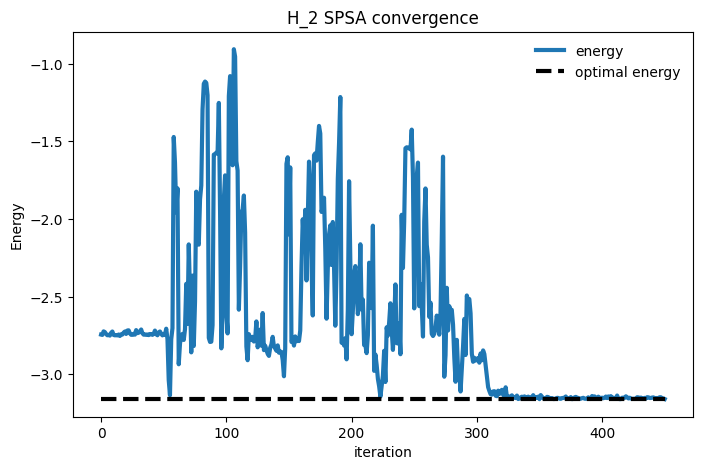

In [27]:
plot_convergence(values_hist, 3)

In [25]:
exact_energies = []
for dist in dists:
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    calculation_base_energy = min_energy - nuclear_repulsion_energy
    exact_energies.append([calculation_base_energy, min_energy, nuclear_repulsion_energy])

In [26]:
target_energies = [exact_energies_i[1] for exact_energies_i in exact_energies]

In [27]:
calculated_energies = []
for i, dist in enumerate(dists):
#     paulis, coeffs = get_paulis_and_coeffs(dist)
    cur_values = values_hist[dist]
    calculated_energy = min(cur_values).real + all_coeffs[i][0] + exact_energies[i][2]
    calculated_energies.append(calculated_energy)

/Users/dekelmeirom/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


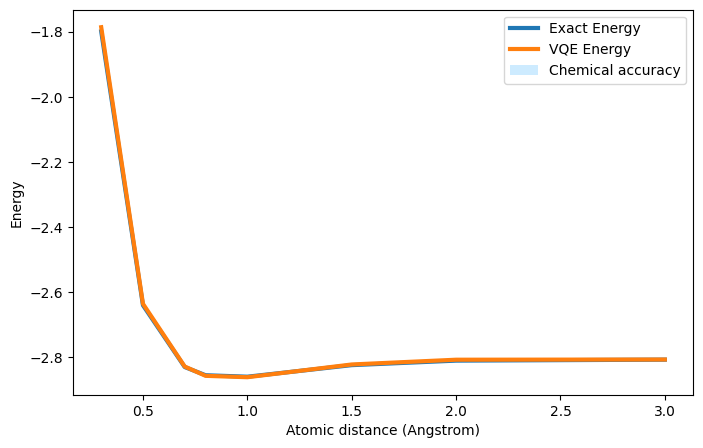

In [31]:
plot_energies(target_energies, calculated_energies, dists)